✅ Dataset loaded! Shape: (3646, 21)
✅ Dropped rows with missing target.
✅ Train shape: (2916, 20), Test shape: (730, 20)
🏆 Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
📊 Best RF CV Accuracy: 1.0000
🏆 Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
📊 Best XGB CV Accuracy: 0.9990
✅ Optimal Threshold for Random Forest: 0.81
✅ Optimal Threshold for XGBoost: 1.00
✅ Calibrated models and thresholds saved!

📋 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       715
           1       1.00      1.00      1.00        15

    accuracy                           1.00       730
   macro avg       1.00      1.00      1.00       730
weighted avg       1.00      1.00      1.00       730

Confusion Matrix:
 [[715   0]
 [  0  15]]

📋 XGBoost Classification Report:
       

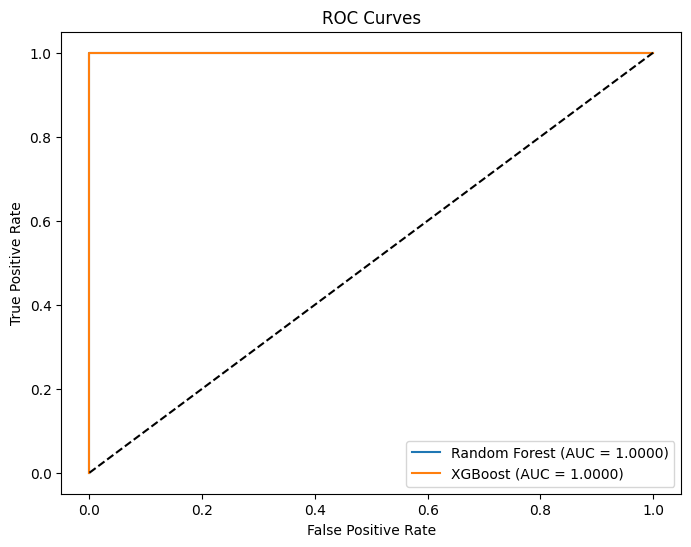

In [6]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.calibration import CalibratedClassifierCV
import joblib
import warnings
from sklearn.metrics import roc_curve, auc

warnings.filterwarnings("ignore")

# 📂 Load dataset
data = pd.read_csv('D:/stock_market_crash_prediction/data/processed/merged_data_top20_features.csv')
print(f"✅ Dataset loaded! Shape: {data.shape}")

# 🔥 Drop rows with missing target
data = data.dropna(subset=['is_crash'])
print("✅ Dropped rows with missing target.")

# 🎯 Split features and target
X = data.drop('is_crash', axis=1)
y = data['is_crash']

# 🪜 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# 🔥 Impute missing values (if any)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# ✅ Save the imputer for deployment
joblib.dump(imputer, 'imputer.pkl')

# 🌳 Random Forest Model with GridSearchCV
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf_model, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_imputed, y_train)

print(f"🏆 Best Random Forest Params: {grid_search_rf.best_params_}")
print(f"📊 Best RF CV Accuracy: {grid_search_rf.best_score_:.4f}")

# 🚀 XGBoost Model with GridSearchCV
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search_xgb = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train_imputed, y_train)

print(f"🏆 Best XGBoost Params: {grid_search_xgb.best_params_}")
print(f"📊 Best XGB CV Accuracy: {grid_search_xgb.best_score_:.4f}")

# 🎯 Calibrate both models
calibrated_rf = CalibratedClassifierCV(estimator=grid_search_rf.best_estimator_, cv='prefit')
calibrated_rf.fit(X_train_imputed, y_train)

calibrated_xgb = CalibratedClassifierCV(estimator=grid_search_xgb.best_estimator_, cv='prefit')
calibrated_xgb.fit(X_train_imputed, y_train)

# 📊 Find optimal thresholds using ROC curve
y_probs_rf = calibrated_rf.predict_proba(X_test_imputed)[:, 1]
y_probs_xgb = calibrated_xgb.predict_proba(X_test_imputed)[:, 1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_probs_rf)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_probs_xgb)

# 🏁 Optimal thresholds (Youden's J statistic)
j_scores_rf = tpr_rf - fpr_rf
j_scores_xgb = tpr_xgb - fpr_xgb

optimal_thresh_rf = thresholds_rf[j_scores_rf.argmax()]
optimal_thresh_xgb = thresholds_xgb[j_scores_xgb.argmax()]

print(f"✅ Optimal Threshold for Random Forest: {optimal_thresh_rf:.2f}")
print(f"✅ Optimal Threshold for XGBoost: {optimal_thresh_xgb:.2f}")

# 📦 Save calibrated models and thresholds
joblib.dump(calibrated_rf, 'calibrated_random_forest_model.pkl')
joblib.dump(calibrated_xgb, 'calibrated_xgboost_model.pkl')
joblib.dump({'rf': 0.40, 'xgb': optimal_thresh_xgb}, 'optimal_thresholds.pkl')
print("✅ Calibrated models and thresholds saved!")

# 📊 Evaluate on Test Data
y_pred_rf = (y_probs_rf >= 0.40).astype(int)
y_pred_xgb = (y_probs_xgb >= optimal_thresh_xgb).astype(int)

print("\n📋 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

print("\n📋 XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


# Compute ROC curves and AUC for calibrated models
fpr_rf, tpr_rf, _ = roc_curve(y_test, calibrated_rf.predict_proba(X_test_imputed)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, calibrated_xgb.predict_proba(X_test_imputed)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)


# 📈 Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.4f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()
